# ARID1A proteomics cis comparison

ARID1A is frequently mutated in the endometrial and colon datasets (> %20 mutated). "The ARID1A gene provides instructions for making a protein that forms one piece (subunit) of several different SWI/SNF protein complexes. SWI/SNF complexes regulate gene activity (expression) by a process known as chromatin remodeling" (Genetic Home Reference, search ARID1A https://ghr.nlm.nih.gov/gene/ARID1A).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [4]:
en_object = cptac.Endometrial()
desired_cutoff = .2

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n', endometrial_freq_mut)

                                    

Number of Frequently Mutated Genes: 10 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ARID1A            0.452632      0.136842        0.400000
1    CTCF            0.284211      0.094737        0.242105
2  CTNNB1            0.305263      0.305263        0.000000
3   KMT2B            0.242105      0.115789        0.126316
4    KRAS            0.326316      0.326316        0.000000
5  PIK3CA            0.494737      0.484211        0.010526
6  PIK3R1            0.389474      0.231579        0.189474
7    PTEN            0.789474      0.463158        0.568421
8    TP53            0.221053      0.157895        0.073684
9   ZFHX3            0.221053      0.084211        0.168421


## Step 3: Select ARID1A, a frequently mutated gene

In [5]:
gene = 'ARID1A'

## Step 4: Select proteomics

In [6]:
omics = en_object.get_proteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [7]:
en_status = f.format_cis_comparison_data(en_object, omics, 'proteomics', gene)
en_status.head()

,ARID1A_proteomics,binary_mutations
Sample_ID,,
S001,-0.8790,Mutated
S002,-1.4100,Mutated
S003,-1.0400,Wildtype
S005,0.3850,Wildtype
S006,0.0106,Wildtype


In [8]:
omics_col_list = ['ARID1A_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(en_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10


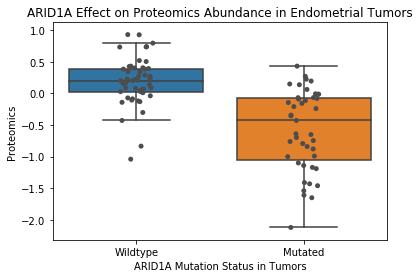

In [9]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
en_cis_boxplot = sns.boxplot(data = en_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= en_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

Repeat the above steps this time comparing missence and truncation mutation types.

In [15]:
en_type = f.get_missence_truncation_comparison(en_object, omics, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(en_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


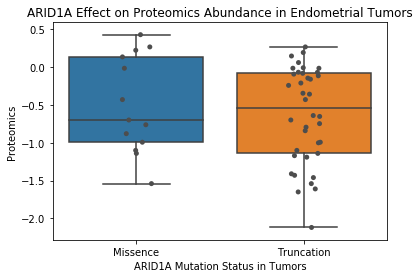

In [16]:
en_cis_boxplot = sns.boxplot(data = en_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= en_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missence","Truncation"])
en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [17]:
colon_object = cptac.Colon()
desired_cutoff = .2

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n', colon_freq_mut.head())

                                    

Number of Frequently Mutated Genes: 39 
       Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0   ACVR2A            0.257732      0.020619        0.257732
1   AHNAK2            0.216495      0.195876        0.030928
2      APC            0.845361      0.113402        0.824742
3   ARID1A            0.237113      0.072165        0.185567
4  CCDC168            0.298969      0.195876        0.195876


In [18]:
gene = 'ARID1A'

co_omics = colon_object.get_proteomics()

Doing t-test comparison for mutation type

          Comparison   P_Value
0  ARID1A_proteomics  0.001305


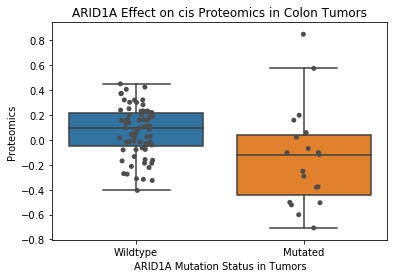

In [19]:
co_status = f.format_cis_comparison_data(colon_object, co_omics, 'proteomics', gene)
#co_data_for_comparison.head()

print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(co_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

cis_boxplot = sns.boxplot(data = co_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on cis Proteomics in Colon Tumors")
cis_boxplot = sns.stripplot(data = co_status, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

Doing t-test comparison for mutation type

No significant comparisons.
None


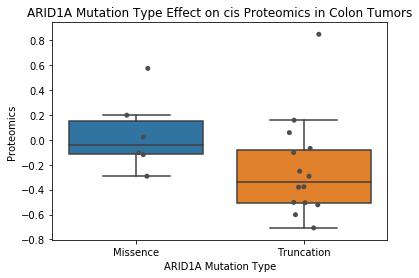

In [20]:
co_type = f.get_missence_truncation_comparison(colon_object, co_omics, 'proteomics', gene)

print("Doing t-test comparison for mutation type\n")
significant_pval_results = al.wrap_ttest(co_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)


co_cis_boxplot = sns.boxplot(data = co_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
co_cis_boxplot.set_title(gene + " Mutation Type Effect on cis Proteomics in Colon Tumors")
co_cis_boxplot = sns.stripplot(data= co_type, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Missence","Truncation"])
co_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')
plt.show()

# Visualize Pancancer effects

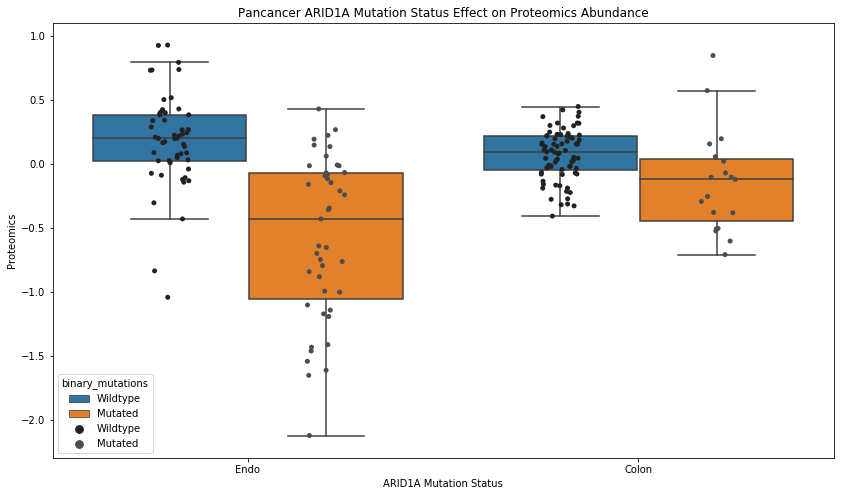

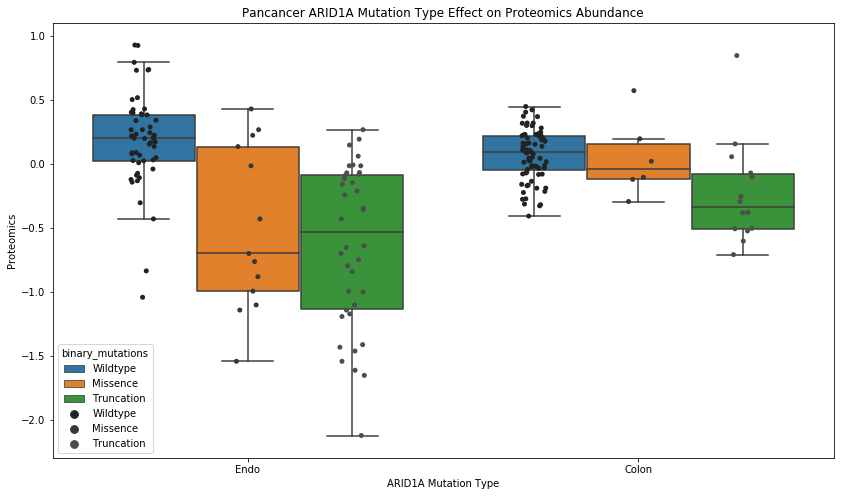

In [21]:
# Create a dataframe with pancancer data for mutation status and type
en_mut_status = en_status.assign(Cancer= 'Endo')
co_mut_status = co_status.assign(Cancer= 'Colon')
en_mut_type = en_type.assign(Cancer= 'Endo')
co_mut_type = co_type.assign(Cancer= 'Colon')

pancancer_data = pd.concat([en_mut_status, co_mut_status, en_mut_type, co_mut_type]) 
pancancer_df = pd.melt(pancancer_data, id_vars=['Cancer','binary_mutations'], value_name= 'Proteomics')  

# Visualize mutation status (mutated vs wildtype) accross cancers
plt.rcParams['figure.figsize']=(14,8) #size of plot
cis_status = sns.boxplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data=pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Status Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data=pancancer_df,
                            jitter = True, color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Status", ylabel = 'Proteomics')

plt.show()

plt.clf()
plt.close()

# Visualize mutation status (missense vs truncation) accross cancers
plt.rcParams['figure.figsize']=(14,8) #size of plot
cis_status = sns.boxplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Missence', 'Truncation'], data = pancancer_df, showfliers = False)    
cis_status.set_title('Pancancer ' + gene + " Mutation Type Effect on Proteomics Abundance")
cis_status = sns.stripplot(x='Cancer', y="Proteomics", hue = 'binary_mutations', data = pancancer_df, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Missence', 'Truncation'], dodge = True)
cis_status.set(xlabel = gene + " Mutation Type", ylabel = 'Proteomics')

plt.show()

plt.clf()
plt.close()

# Analysis of Results

Endometrial and colon tumors showed decreased proteomic abundance for the tumors with the mutated gene compared to the wildtype, with endometrial tumors showing the most difference.
All other results were insignificant.